# Imports

In [1]:
from datetime import timedelta
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

from icedef import iceberg, metocean, drift_simulation, plot
from icedef.turnbull import drift

# Iceberg

In [2]:
df = pd.read_csv('csvs/0204980_2015.csv')

In [3]:
df['DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])

In [4]:
times = [t.to_pydatetime() for t in df['DataDate_UTC']]

In [5]:
lons = df['Longitude']

In [6]:
lats = df['Latitude']

In [7]:
ref_berg = iceberg.Iceberg('0204980_2015', times[0], lons[0], lats[0], 0, 0, 0, 0, 'LG', 'TAB')

In [8]:
ref_berg.history['T'] = times[:1000]
ref_berg.history['X'] = lons[:1000]
ref_berg.history['Y'] = lats[:1000]

In [9]:
berg = iceberg.clone_iceberg_state(ref_berg)

# Metocean

In [10]:
ocean_data = metocean.ECMWFOcean(ref_berg.history['T'][0], ref_berg.history['T'][-1])

#ocean_data.filenames

In [11]:
atm_data = metocean.NARRAtm(ref_berg.history['T'][0], ref_berg.history['T'][-1])

#atm_data.filenames

# Drift Simulation

In [12]:
sim = drift_simulation.DriftSimulation(berg, ocean_data, atm_data, drift)

In [13]:
dt = 0.1*3600
t0 = ref_berg.history['T'][0]
tf = ref_berg.history['T'][-1]
tdelta = tf - t0
tdelta_secs = tdelta.days*12*3600 + tdelta.seconds
nt = int(tdelta_secs//dt)

In [14]:
#sim.euler(dt,nt)
sim.rk2(dt, nt)

In [15]:
sim.history.head()

,t,vax,vay,vcx,vcy,vx,vy,x,y
0,2015-04-24 15:16:06,-3.217008,-0.978001,0.043383,0.073384,0.000000,0.000000,-51.551440,51.459910
1,2015-04-24 15:22:06,-3.243216,-0.949190,0.043929,0.072737,-0.002218,0.003565,-51.551452,51.459922
2,2015-04-24 15:28:06,-3.269427,-0.920377,0.044472,0.072088,-0.004213,0.006780,-51.551473,51.459943
3,2015-04-24 15:34:06,-3.295639,-0.891564,0.044688,0.071257,-0.006009,0.009689,-51.551505,51.459975
4,2015-04-24 15:40:06,-3.321854,-0.862750,0.044751,0.070342,-0.007651,0.012316,-51.551544,51.460015


# Plot

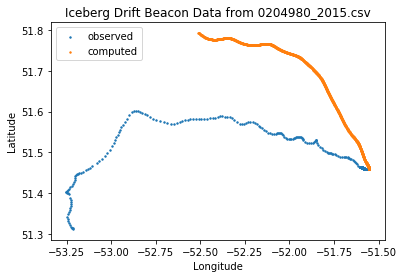

In [16]:
plt.scatter(ref_berg.history['X'], ref_berg.history['Y'], s=2, label='observed')
plt.scatter(sim.history['x'], sim.history['y'], s=2, label='computed')
plt.title('Iceberg Drift Beacon Data from 0204980_2015.csv')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

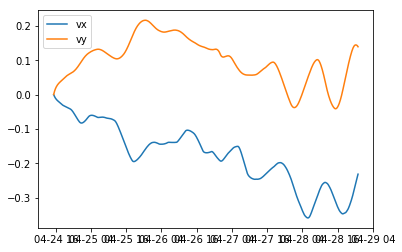

In [17]:
plt.plot(sim.history['t'], sim.history['vx'], label='vx')
plt.plot(sim.history['t'], sim.history['vy'], label='vy')
plt.legend()
plt.show()

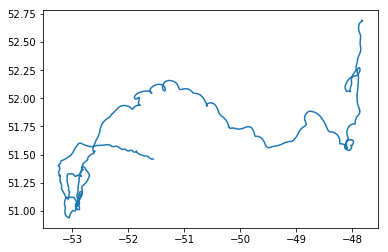

In [18]:
plt.plot(df['Longitude'], df['Latitude'])
plt.show()

In [19]:
from mpl_toolkits.basemap import Basemap
from matplotlib.animation import FuncAnimation

from scipy.interpolate import RegularGridInterpolator as RGI

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [33]:
def metocean_animation(drift_track, data_grid, data, fname='field_anim',
                       vmin=0, vmax=1, scale=1, headwidth=5, width=5e-3):
    
    x_vec = drift_track[0]
    y_vec = drift_track[1]
    t_vec = drift_track[2]
    
    grid_t = data_grid[0]
    grid_y = data_grid[1]
    grid_x = data_grid[2]
    
    data_u = data[0]
    data_v = data[1]
    
    u_RGI = RGI((grid_t, grid_y, grid_x), data_u) 
    v_RGI = RGI((grid_t, grid_y, grid_x), data_v)
    
    lon0 = np.where(grid_x < min(x_vec))[0][-1]
    lonn = np.where(grid_x > max(x_vec))[0][0]
    lat0 = np.where(grid_y < min(y_vec))[0][-1] 
    latn = np.where(grid_y > max(y_vec))[0][0]
    
    u_mat = np.empty([t_vec, len(grid_y[lat0-1:latn+1]), len(grid_x[lon0-1:lonn+1])])
    v_mat = np.empty([t_vec, len(grid_y[lat0-1:latn+1]), len(grid_x[lon0-1:lonn+1])])
    
    for i, ival in enumerate(t_vec):
        for j, jval in enumerate(grid_y[lat0-1:latn+1]):
            for k, kval in enumerate(grid_x[lon0-1:lonn+1]):
                u_mat[i][j][k] = u_RGI([ival,jval,kval])
                v_mat[i][j][k] = v_RGI([ival,jval,kval])
                
    
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([grid_x[lon0], grid_x[lonn], grid_y[lat0], grid_y[latn]], 
                  ccrs.PlateCarree())
    
    #ax.stock_img()
    ax.coastlines('50m')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=True,linewidth=2, color='gray', 
                      alpha=0.5, linestyle='--')
    
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    
    #ax.scatter(x_vec, y_vec, color='black')
    w_mat = np.sqrt(u_mat**2 + v_mat**2)
    im = plt.imshow(w_mat[0,:,:], 
                    extent=[grid_x[lon0-1], grid_x[lonn+1], 
                            grid_y[lat0-1], grid_y[latn+1]],
                    origin = 'lower', vmin=vmin, vmax=vmax)
    
    line, = plt.plot(x_vec[0], y_vec[0], color='black')
    
    plt.colorbar()
    
    quiv = plt.quiver(grid_x[lon0-1:lonn+1], grid_y[lat0-1:latn+1], 
                      u_mat[0,:,:], v_mat[0,:,:], 
                      scale=scale, headwidth=headwidth, width=width)
    
    title = plt.title('time: 0 hours')


    def animate(i):
        im.set_data(w_mat[i,:,:])
        quiv.set_UVC(u_mat[i,:,:], v_mat[i,:,:])
        title.set_text('time: {:.0f} hours'.format(t_vec[i]-t_vec[0]))
        line.set_data(x_vec[0:i+1], y_vec[0:i+1])
        return im, line
    
    
    anim = FuncAnimation(fig, animate, frames=w_mat[:,0,0].size-1, interval=100)
    #HTML(anim.to_html5_video())
    anim.save(f'plots/{fname}.gif',writer='imagemagick')
    

In [40]:
np.arange(0, 1, 0.3)

array([0. , 0.3, 0.6, 0.9])

In [81]:
def berg_metocean_animation(x_berg, y_berg, t_berg, x0, xf, dx, y0, yf, dy, t0, tf, dt, x_data, 
                            y_data, t_data, u_data, v_data, 
                            fname='field_anim', vmin=0, vmax=1, scale=1, headwidth=5, width=5e-3):
    
    
    t_grid = np.arange(t0, tf, dt)
    x_grid = np.arange(x0, xf, dx)
    y_grid = np.arange(y0, yf, dy)
    
    u_RGI = RGI((t_data, y_data, x_data), u_data) 
    v_RGI = RGI((t_data, y_data, x_data), v_data)    
    
    u_mat = np.empty([len(t_grid), len(y_grid), len(x_grid)])
    v_mat = np.empty([len(t_grid), len(y_grid), len(x_grid)])
    
    for i, ival in enumerate(t_grid):
        for j, jval in enumerate(y_grid):
            for k, kval in enumerate(x_grid):
                u_mat[i][j][k] = u_RGI([ival,jval,kval])
                v_mat[i][j][k] = v_RGI([ival,jval,kval])
                
    
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([x0, xf, y0, yf], 
                  ccrs.PlateCarree())
    
    #ax.stock_img()
    ax.coastlines('50m')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=True,linewidth=2, color='gray', 
                      alpha=0.5, linestyle='--')
    
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    
    #ax.scatter(x_vec, y_vec, color='black')
    w_mat = np.sqrt(u_mat**2 + v_mat**2)
    im = plt.imshow(w_mat[0,:,:], 
                    extent=[x0, xf, y0, yf],
                    origin = 'lower', vmin=vmin, vmax=vmax)
    
    #line, = plt.plot(x_vec[0], y_vec[0], color='black')
    
    plt.colorbar()
    
    #quiv = plt.quiver(grid_x[lon0-1:lonn+1], grid_y[lat0-1:latn+1], 
    #                  u_mat[0,:,:], v_mat[0,:,:], 
    #                  scale=scale, headwidth=headwidth, width=width)
    
    #title = plt.title('time: 0 hours')


    def animate(i):
        im.set_data(w_mat[i,:,:])
        #quiv.set_UVC(u_mat[i,:,:], v_mat[i,:,:])
        #title.set_text('time: {:.0f} hours'.format(t_vec[i]-t_vec[0]))
        #line.set_data(x_vec[0:i+1], y_vec[0:i+1])
        return im#, line
    
    
    print(w_mat[:,0,0].size)
    anim = FuncAnimation(fig, animate, frames=w_mat[:,0,0].size-1, interval=100)
    #HTML(anim.to_html5_video())
    anim.save(f'plots/{fname}.gif',writer='imagemagick')
    

12


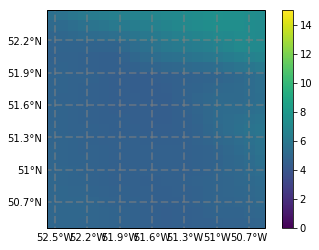

In [82]:
x_berg = sim.history['x'][:100]
y_berg = sim.history['y'][:100]
t_berg = nc.date2num(sim.history['t'][:100], atm_data.T_UNITS, atm_data.T_CALENDAR)

x0 = min(x_berg)-1; xf = max(x_berg)+1; dx = 0.1
y0 = min(y_berg)-1; yf = max(y_berg)+1; dy = 0.1
t0 = min(t_berg)-1; tf = max(t_berg)+1; dt = 1

xid0 = np.where(abs(atm_data.lons - x0) < (atm_data.lons[1]-atm_data.lons[0]))[0][0]
xidf = np.where(abs(atm_data.lons - xf) < (atm_data.lons[1]-atm_data.lons[0]))[0][-1]
yid0 = np.where(abs(atm_data.lats - y0) < (atm_data.lats[1]-atm_data.lats[0]))[0][0]
yidf = np.where(abs(atm_data.lats - yf) < (atm_data.lats[1]-atm_data.lats[0]))[0][-1]
tid0 = np.where(abs(atm_data.times - t0) < (atm_data.times[1]-atm_data.times[0]))[0][0]
tidf = np.where(abs(atm_data.times - tf) < (atm_data.times[1]-atm_data.times[0]))[0][-1]

x_slice = atm_data.lons[xid0:xidf+1]
y_slice = atm_data.lats[yid0:yidf+1]
t_slice = atm_data.times[tid0:tidf+1]

u_data = atm_data.U[tid0:tidf+1, yid0:yidf+1, xid0:xidf+1]
v_data = atm_data.V[tid0:tidf+1, yid0:yidf+1, xid0:xidf+1]


berg_metocean_animation(x_berg, y_berg, t_berg, x0, xf, dx, y0, yf, dy, t0, tf, dt, 
                        x_slice, y_slice, t_slice, u_data, v_data, 
                        fname='wind_anim', vmin=0, vmax=15, scale=20)